Sequential Spotify Music Analysisript analyzes Spotify music data in a step-by-step manner,
demonstrating results immediately after each processing stage.
The final model is trained on all data and saved for future use.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
# Set visual styling for better plots
plt.style.use('seaborn')
sns.set_palette("husl")

<ipython-input-2-a570b089a85e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# Step 1: Data Loading and Initial Exploration
def load_and_explore_data(file_path: str) -> pd.DataFrame:
    """Load and explore initial dataset"""
    df = pd.read_csv(file_path)

    print("Dataset Overview:")
    print("-" * 50)
    print(f"Number of tracks: {len(df)}")
    print(f"Number of features: {len(df.columns)}")
    print("\nFeature List:")
    print(df.columns.tolist())
    print("\nFirst few rows:")
    print(df.head())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nUnique Values:")
    print(df.nunique())
    print("\nData Types:")
    print(df.dtypes)

    return df

In [4]:
# Execute Step 1
print("Step 1: Loading and Exploring Data")
print("-" * 80)
df = load_and_explore_data('/content/drive/MyDrive/ML/Music Popularity/music_analysis.csv')

Step 1: Loading and Exploring Data
--------------------------------------------------------------------------------
Dataset Overview:
--------------------------------------------------
Number of tracks: 1317
Number of features: 25

Feature List:
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'track_uri', 'track_name', 'artist_name', 'artist_popularity', 'artist_genres', 'album_name', 'track_popularity']

First few rows:
   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.696   0.793    8    -5.733     1       0.0970        0.0683   
1         0.574   0.651    7    -7.585     1       0.0460        0.3460   
2         0.691   0.814    1    -3.788     0       0.1170        0.0164   
3         0.660   0.551    8    -8.014     0       0.0278        0.2390   
4         0.668   0.826    

In [5]:
# Step 2: Feature Selection
def select_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Select and explain relevant features.
    Returns a new DataFrame rather than a view to avoid chaining issues.
    """
    features_to_use = [
        # Audio Features
        'danceability',     # How suitable for dancing (0.0 to 1.0)
        'energy',          # Perceptual measure of intensity
        'loudness',        # Overall loudness in dB
        'speechiness',     # Presence of spoken words
        'acousticness',    # Confidence measure of acousticness
        'instrumentalness', # Predicts if track contains no vocals
        'liveness',        # Detects presence of audience
        'valence',         # Musical positiveness
        # Track Metrics
        'tempo',           # Speed or pace of track
        'duration_ms',     # Track length in milliseconds
        # Popularity Metrics
        'artist_popularity',
        'track_popularity'
    ]

    # Create a new DataFrame instead of a view
    df_selected = df[features_to_use].copy()

    print("\nSelected Features Statistics:")
    print(df_selected.describe())

    return df_selected

In [6]:
# Execute Step 2
print("\nStep 2: Feature Selection")
print("-" * 80)
df_selected = select_features(df)


Step 2: Feature Selection
--------------------------------------------------------------------------------

Selected Features Statistics:
       danceability       energy     loudness  speechiness  acousticness  \
count   1317.000000  1317.000000  1317.000000  1317.000000   1317.000000   
mean       0.560488     0.753721    -5.234011     0.072408      0.115511   
std        0.131284     0.125176     1.888920     0.059053      0.151587   
min        0.099300     0.259000   -20.077000     0.025600      0.000036   
25%        0.473000     0.674000    -6.272000     0.040200      0.014200   
50%        0.564000     0.766000    -5.063000     0.050900      0.053200   
75%        0.657000     0.845000    -3.955000     0.078000      0.157000   
max        0.947000     0.994000     1.302000     0.502000      0.881000   

       instrumentalness     liveness      valence        tempo    duration_ms  \
count       1317.000000  1317.000000  1317.000000  1317.000000    1317.000000   
mean          

In [7]:
# Step 3: Exploratory Data Analysis
def perform_eda(df: pd.DataFrame) -> None:
    """Perform and display EDA visualizations"""

    # Distribution Analysis
    plt.figure(figsize=(20, 15))
    for idx, col in enumerate(df.columns[:-1], 1):
        plt.subplot(4, 3, idx)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # Correlation Analysis
    plt.figure(figsize=(12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.show()

    # Track Popularity Distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df['track_popularity'])
    plt.title('Track Popularity Distribution')
    plt.show()

    # Relationships with Popularity
    plt.figure(figsize=(20, 15))
    for idx, col in enumerate(df.columns[:-1], 1):
        plt.subplot(4, 3, idx)
        sns.scatterplot(data=df, x=col, y='track_popularity', alpha=0.5)
        plt.title(f'{col} vs Popularity')
    plt.tight_layout()
    plt.show()


Step 3: Exploratory Data Analysis
--------------------------------------------------------------------------------


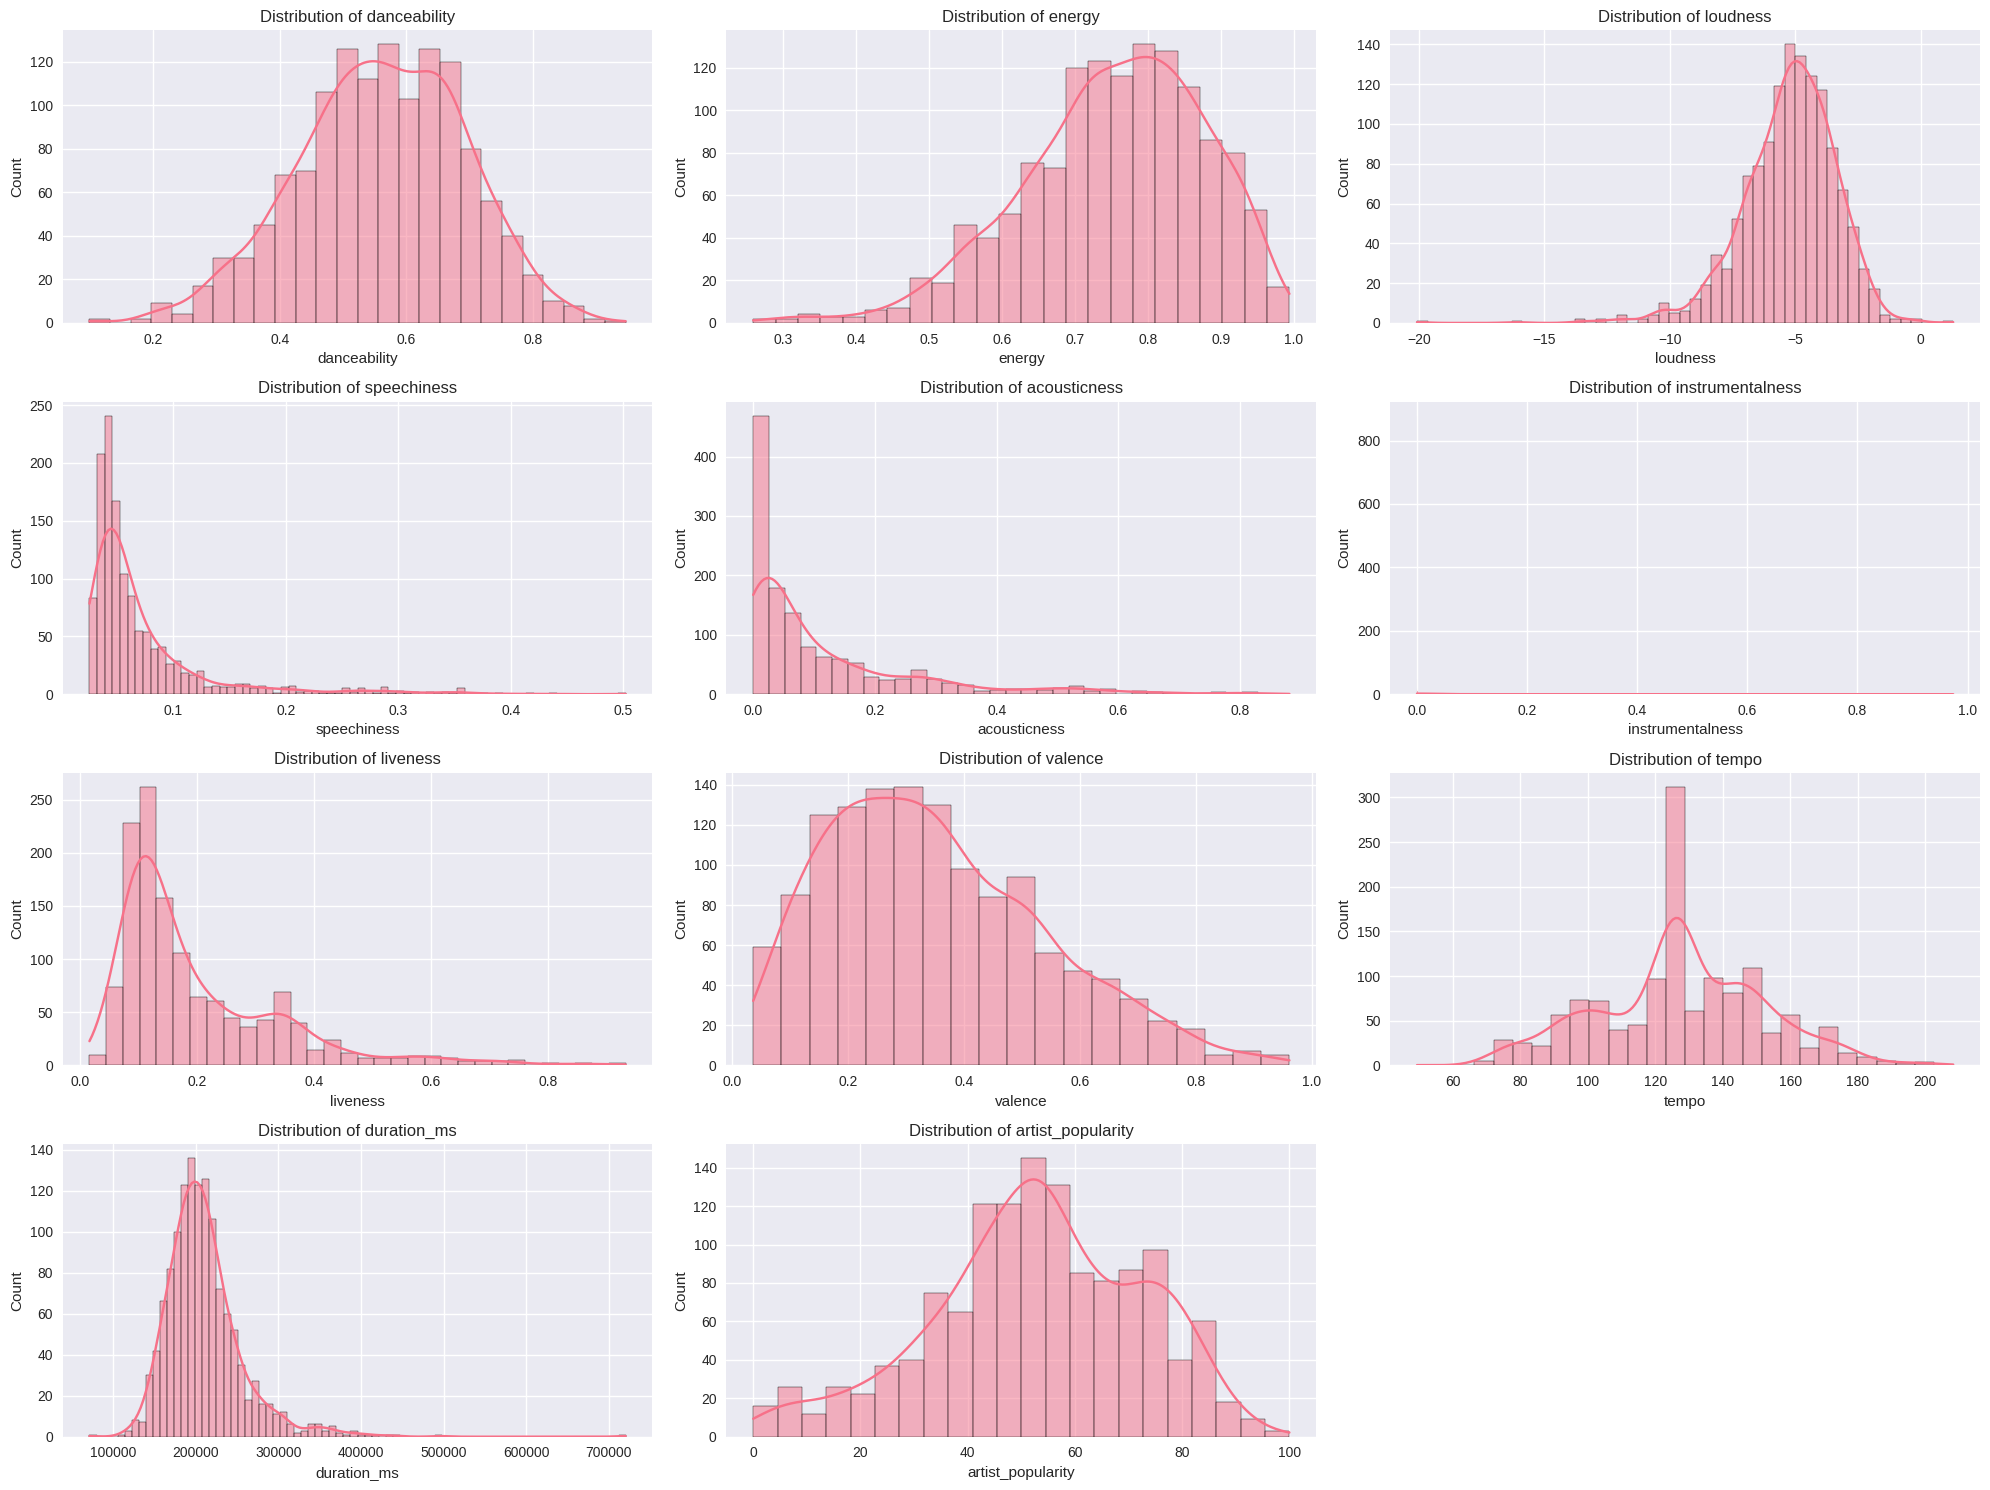

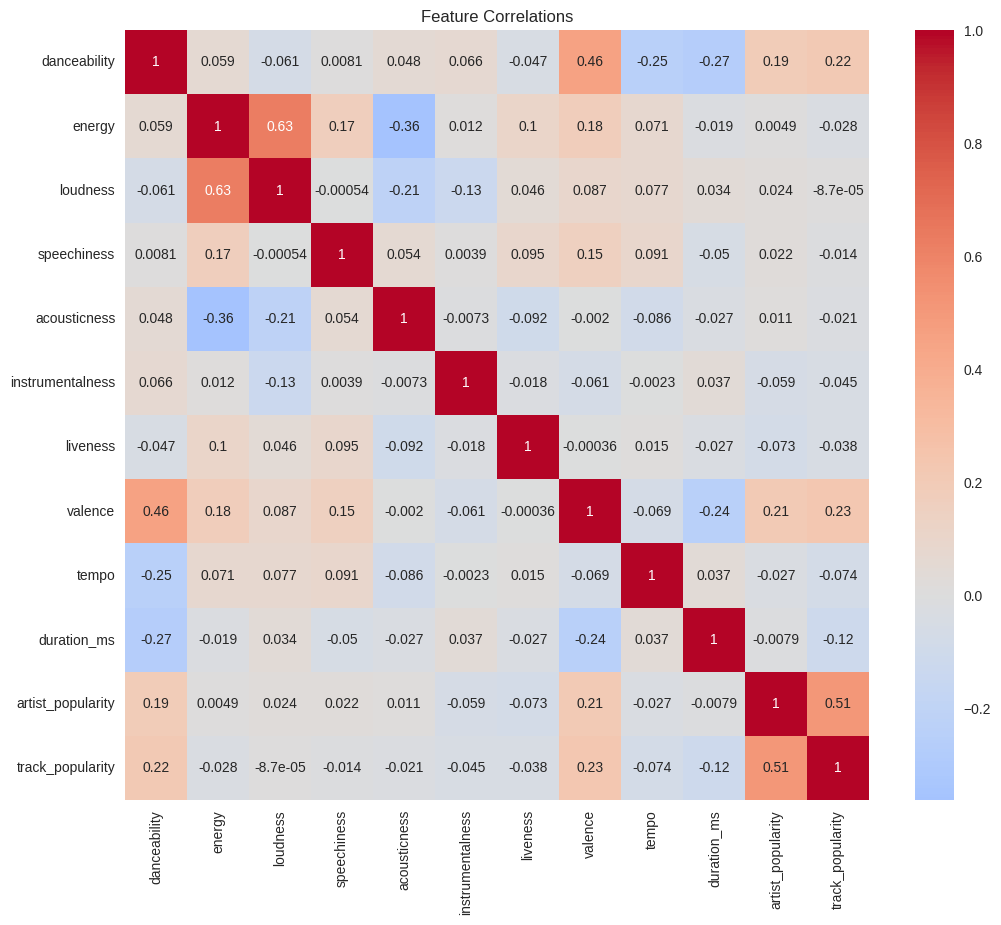

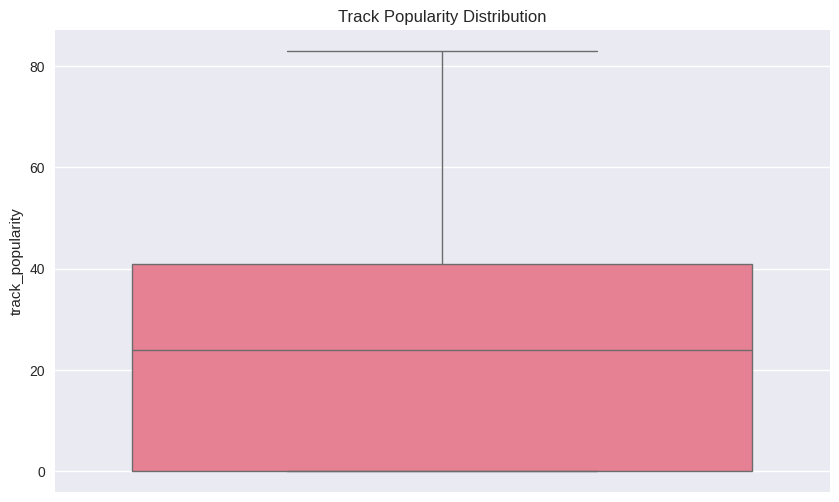

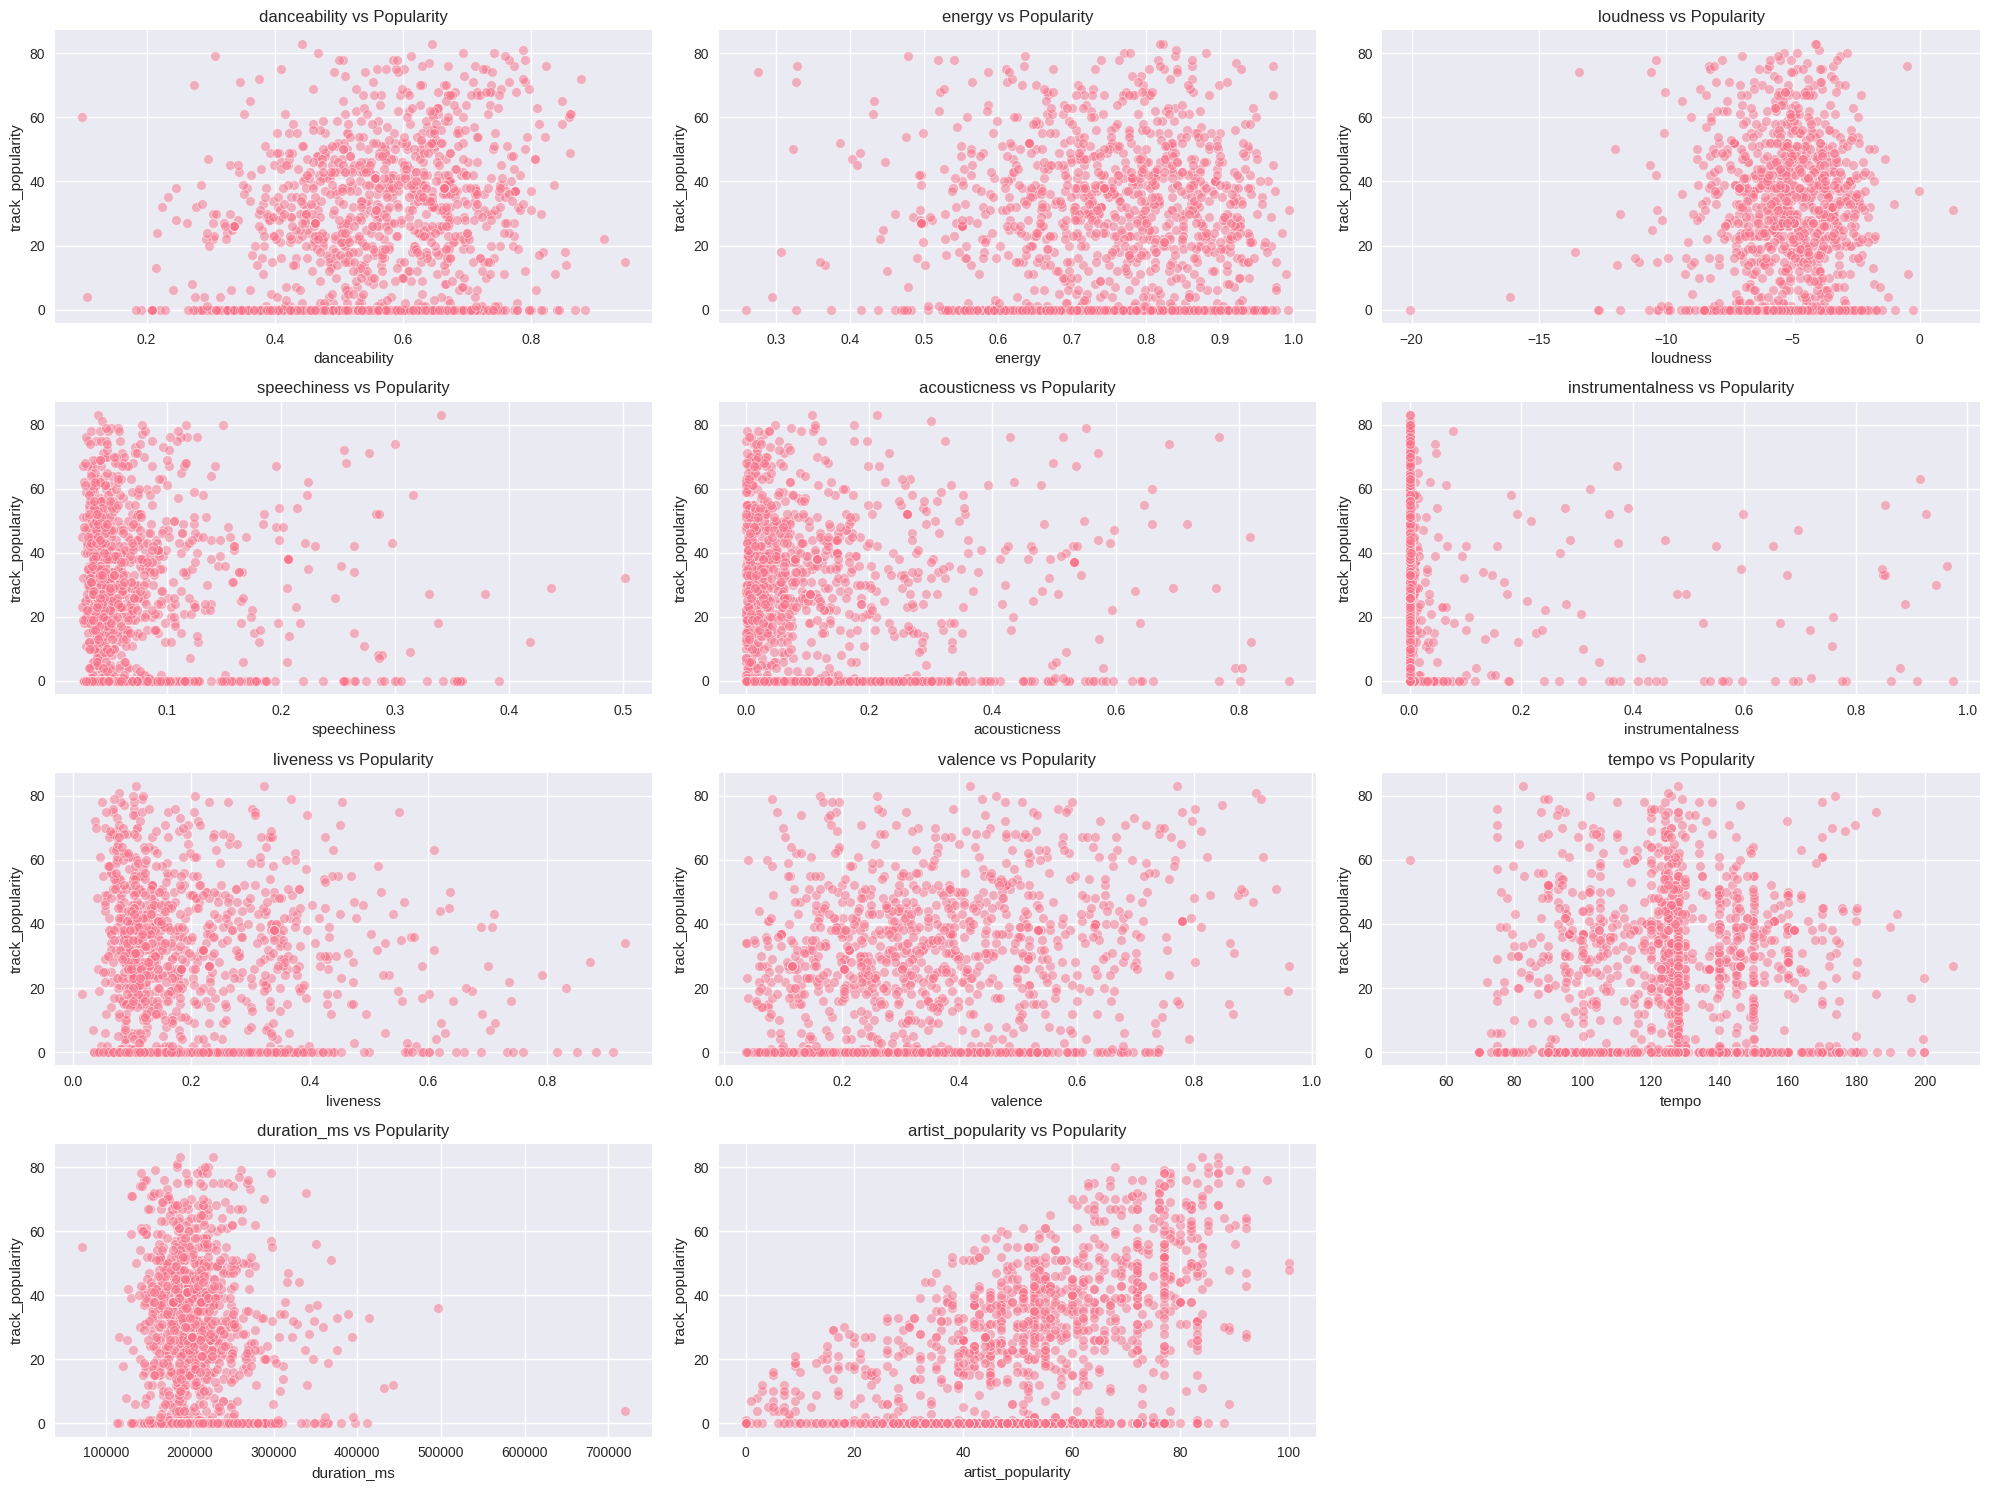

In [8]:
# Execute Step 3
print("\nStep 3: Exploratory Data Analysis")
print("-" * 80)
perform_eda(df_selected)

In [9]:
def preprocess_data(df: pd.DataFrame, popularity_threshold: int = 70) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare data for modeling with proper DataFrame handling
    """
    # Create target variable
    print(f"\nCreating target variable (threshold={popularity_threshold})...")

    # Create target column properly using loc
    df.loc[:, 'is_popular'] = (df['track_popularity'] >= popularity_threshold).astype(int)

    popular_count = df['is_popular'].sum()
    total_count = len(df)

    print(f"Popular tracks: {popular_count}")
    print(f"Unpopular tracks: {total_count - popular_count}")
    print(f"Percentage of popular tracks: {(popular_count/total_count)*100:.2f}%")

    # Separate features and target
    feature_columns = [col for col in df.columns if col not in ['track_popularity', 'is_popular']]
    X = df[feature_columns].values
    y = df['is_popular'].values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save the scaler for future use
    joblib.dump(scaler, '/content/drive/MyDrive/ML/Music Popularity/spotify_scaler.joblib')

    return X_scaled, y

In [10]:
# Execute Step 4
print("\nStep 4: Data Preprocessing")
print("-" * 80)
X, y = preprocess_data(df_selected)


Step 4: Data Preprocessing
--------------------------------------------------------------------------------

Creating target variable (threshold=70)...
Popular tracks: 48
Unpopular tracks: 1269
Percentage of popular tracks: 3.64%


In [11]:
# Step 4.5: Visualize Scaling Effect
def visualize_scaling_effect(df: pd.DataFrame, X_scaled: np.ndarray) -> None:
    """
    Visualize the distribution of features before and after scaling.

    Args:
        df: Original DataFrame with selected features
        X_scaled: Scaled feature matrix from StandardScaler
    """
    # Convert scaled array back to DataFrame for easier plotting
    scaled_df = pd.DataFrame(
        X_scaled,
        columns=[col for col in df.columns if col not in ['track_popularity', 'is_popular']]
    )

    # Create visualization
    n_features = len(scaled_df.columns)
    n_rows = (n_features + 1) // 2  # Calculate number of rows needed

    plt.figure(figsize=(20, 4*n_rows))

    for idx, column in enumerate(scaled_df.columns, 1):
        # Original distribution
        plt.subplot(n_rows, 4, 2*idx-1)
        sns.histplot(data=df[column], kde=True, color='blue', alpha=0.6)
        plt.title(f'Original Distribution: {column}')
        plt.xlabel('Original Values')

        # Scaled distribution
        plt.subplot(n_rows, 4, 2*idx)
        sns.histplot(data=scaled_df[column], kde=True, color='green', alpha=0.6)
        plt.title(f'Scaled Distribution: {column}')
        plt.xlabel('Scaled Values')

    plt.tight_layout()
    plt.show()

    # Box plots to show the effect of scaling
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df.drop(['track_popularity', 'is_popular'], axis=1))
    plt.xticks(rotation=45)
    plt.title('Feature Distributions Before Scaling')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=scaled_df)
    plt.xticks(rotation=45)
    plt.title('Feature Distributions After Scaling')

    plt.tight_layout()
    plt.show()

    # Print scaling statistics
    print("\nScaling Statistics:")
    print("\nBefore Scaling:")
    print(df.drop(['track_popularity', 'is_popular'], axis=1).describe().round(2))
    print("\nAfter Scaling:")
    print(scaled_df.describe().round(2))


Step 4.5: Visualizing Scaling Effect
--------------------------------------------------------------------------------


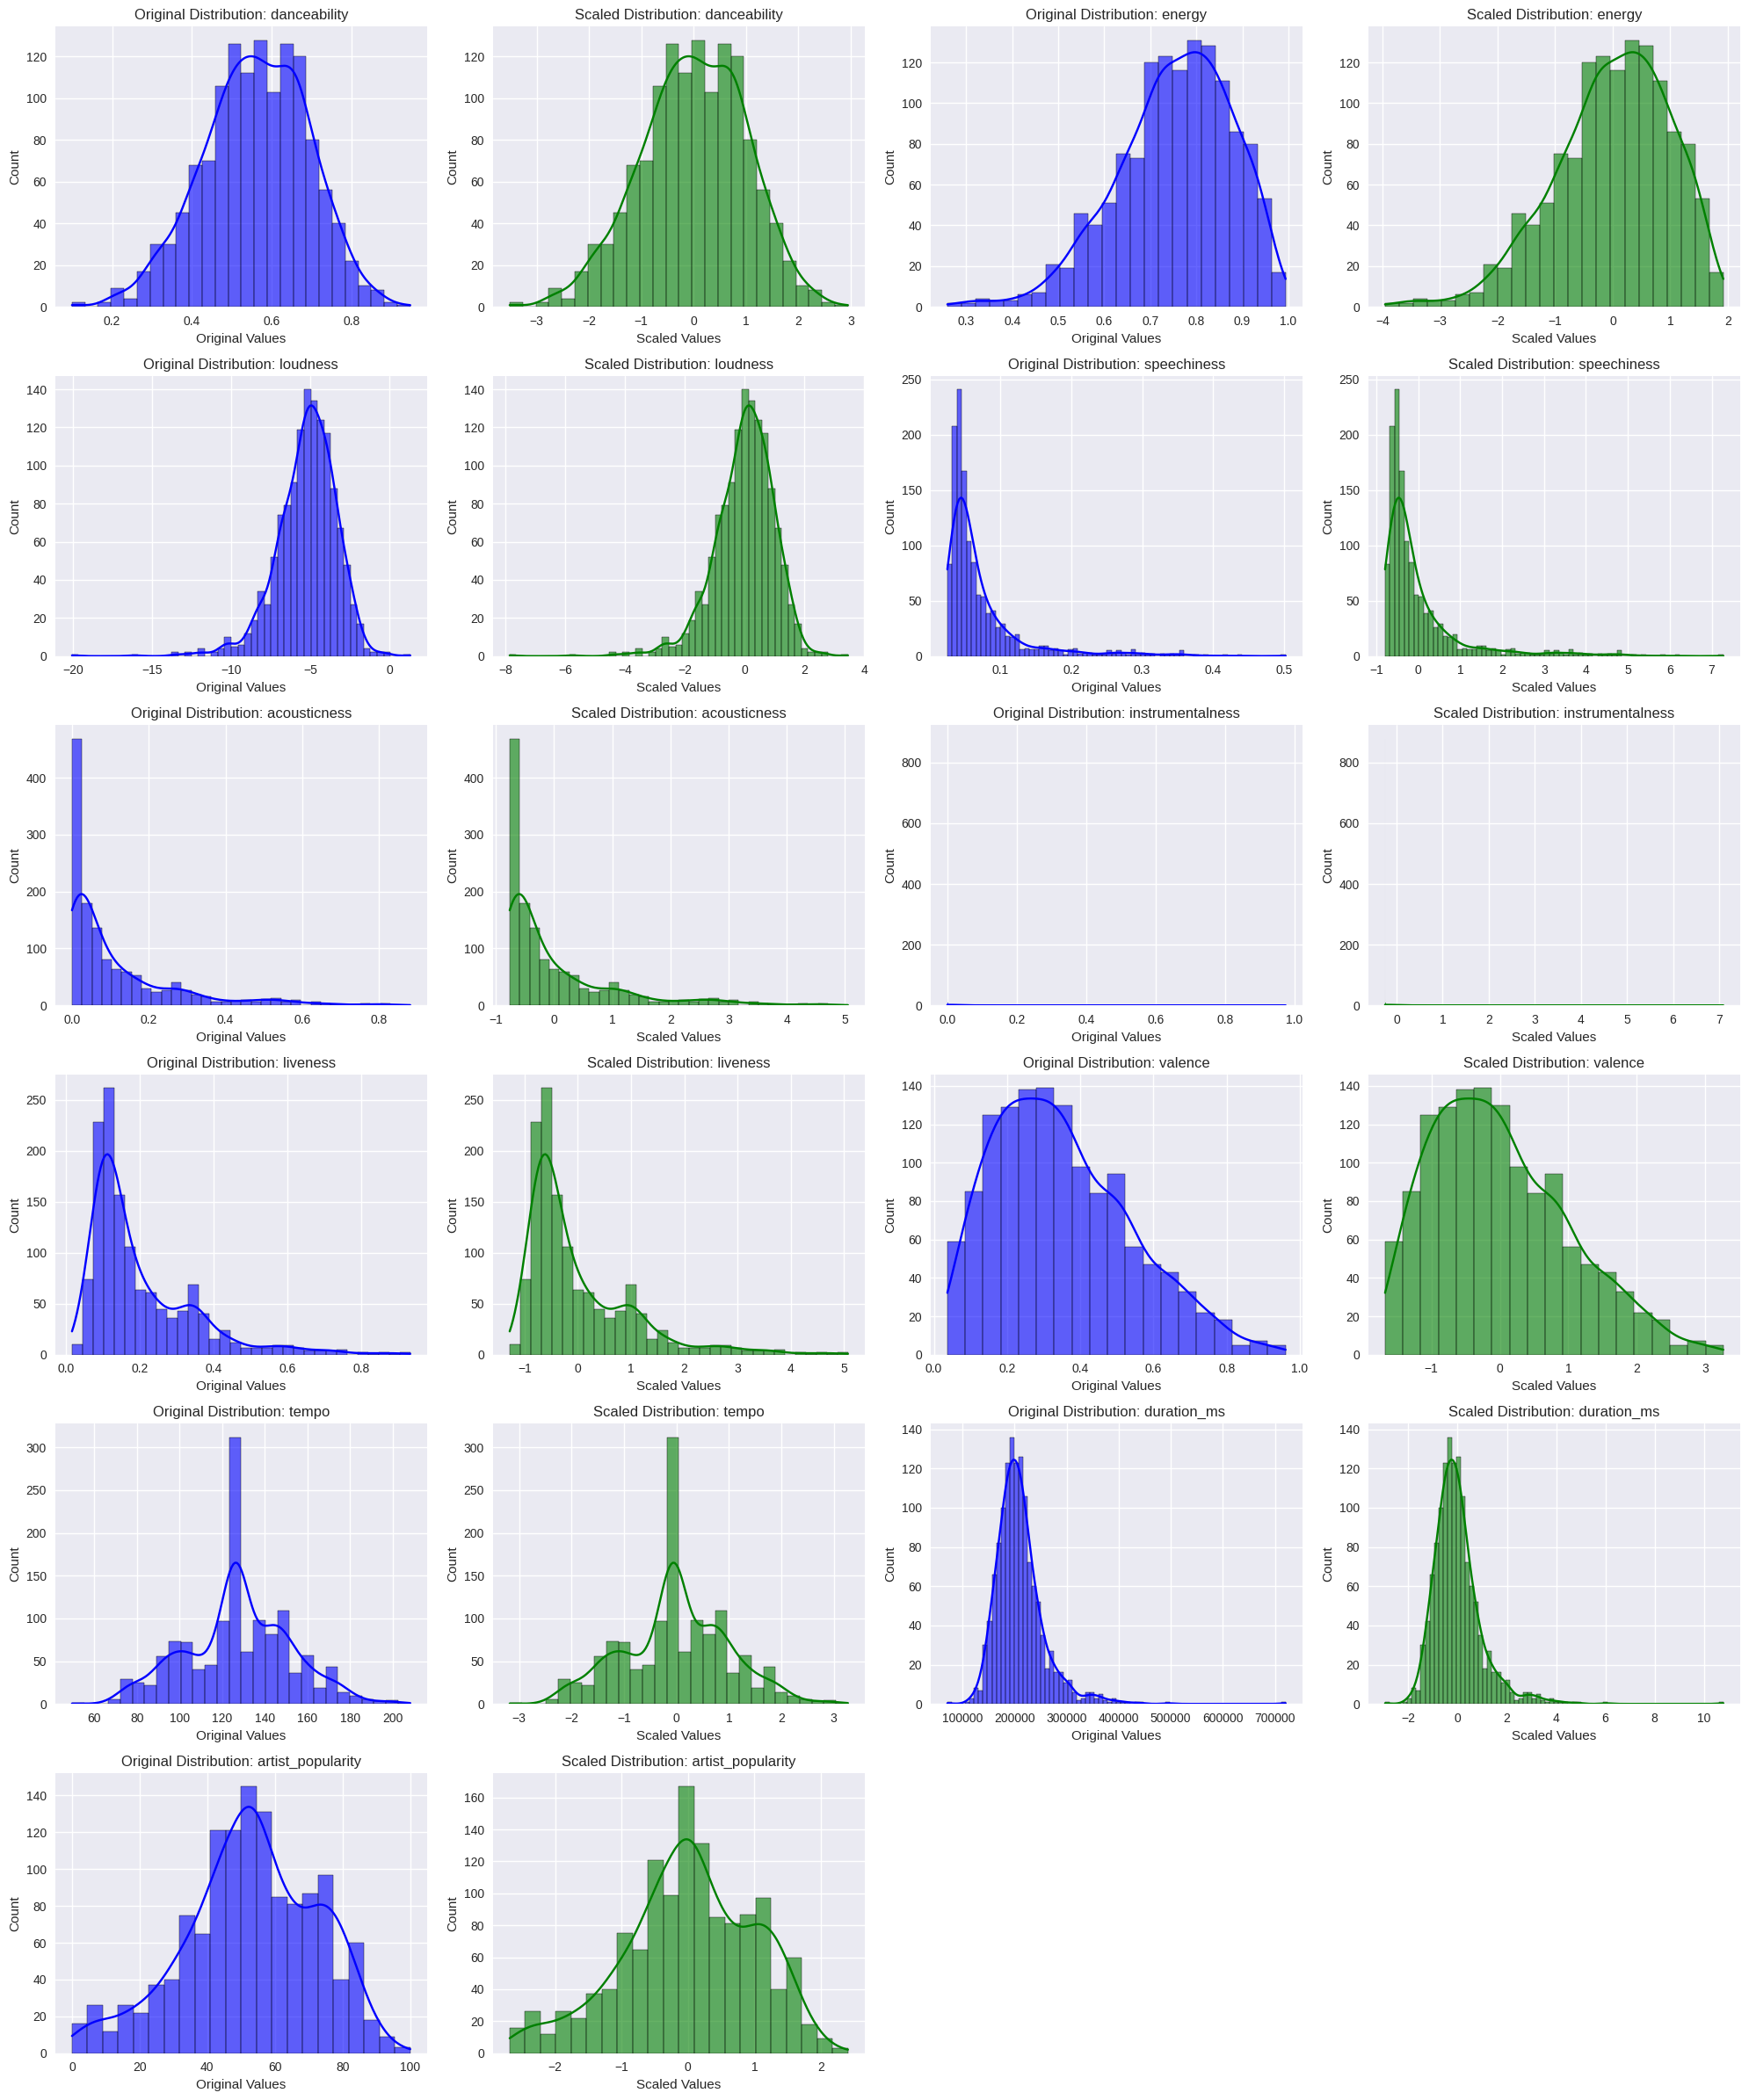

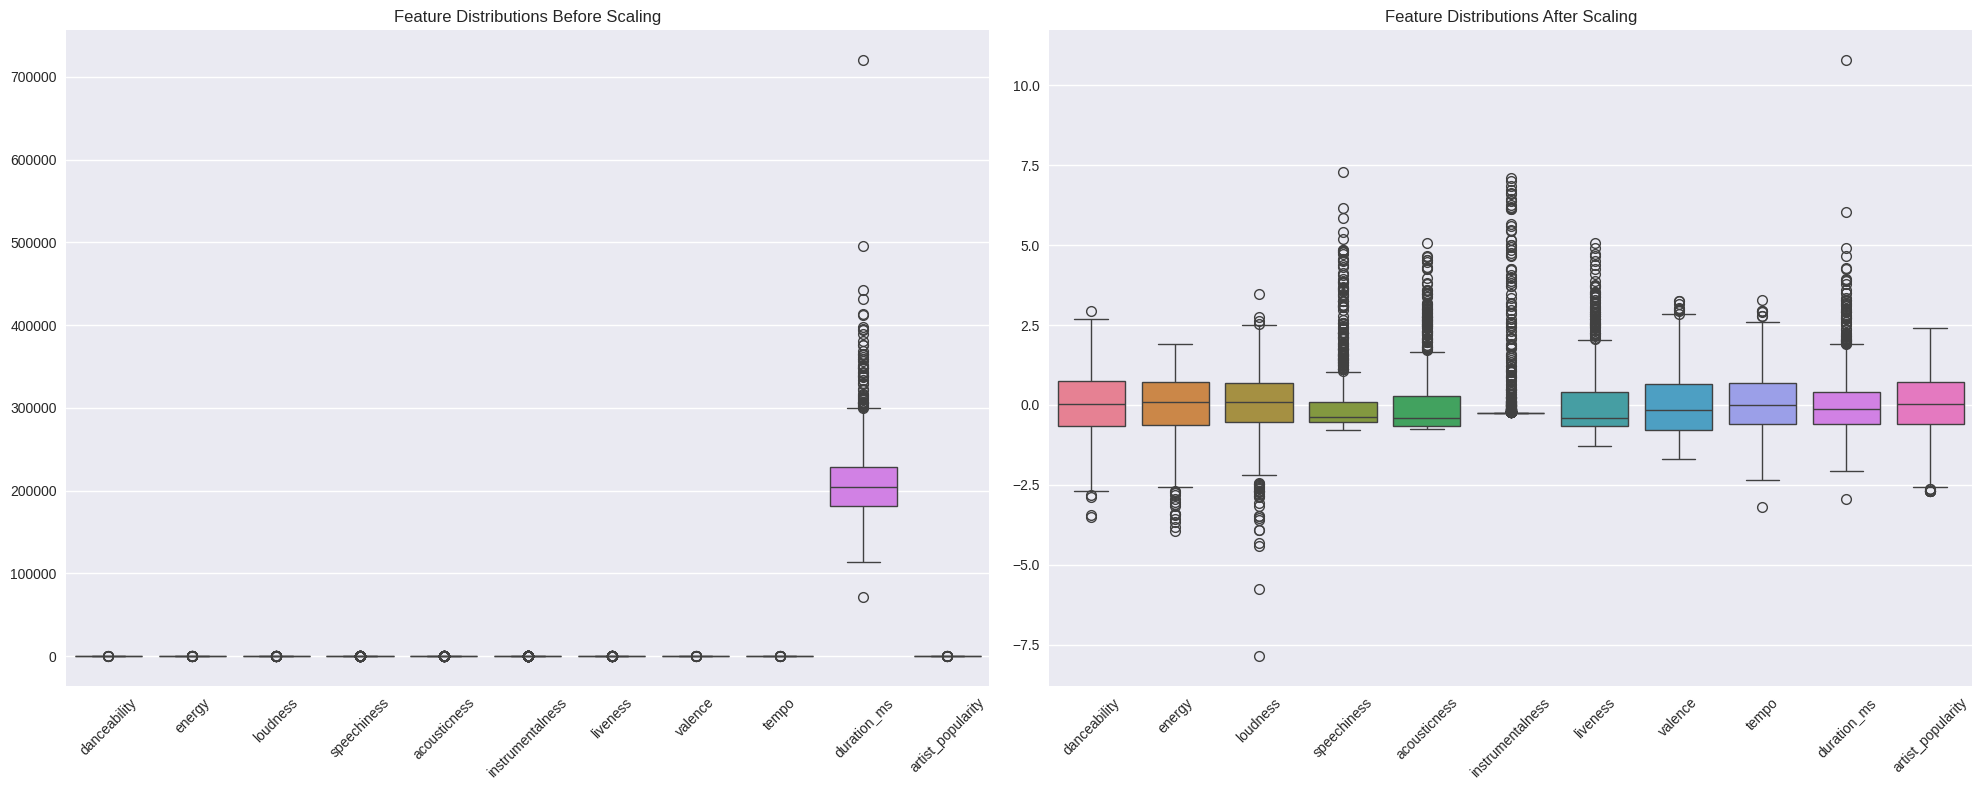


Scaling Statistics:

Before Scaling:
       danceability   energy  loudness  speechiness  acousticness  \
count       1317.00  1317.00   1317.00      1317.00       1317.00   
mean           0.56     0.75     -5.23         0.07          0.12   
std            0.13     0.13      1.89         0.06          0.15   
min            0.10     0.26    -20.08         0.03          0.00   
25%            0.47     0.67     -6.27         0.04          0.01   
50%            0.56     0.77     -5.06         0.05          0.05   
75%            0.66     0.84     -3.96         0.08          0.16   
max            0.95     0.99      1.30         0.50          0.88   

       instrumentalness  liveness  valence    tempo  duration_ms  \
count           1317.00   1317.00  1317.00  1317.00      1317.00   
mean               0.03      0.20     0.35   127.75    210427.52   
std                0.13      0.14     0.19    24.64     47275.75   
min                0.00      0.02     0.04    49.45     71216.00   


In [12]:
# Execute Step 4.5
print("\nStep 4.5: Visualizing Scaling Effect")
print("-" * 80)
visualize_scaling_effect(df_selected, X)

In [15]:
# Step 5: Model Evaluation
def evaluate_model(X: np.ndarray, y: np.ndarray) -> MLPClassifier:
    """Build and evaluate model performance"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train model
    model = MLPClassifier(
        hidden_layer_sizes=(200,150,50),
        max_iter=200,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)

    print(f"Training Accuracy: {train_score:.3f}")
    print(f"Testing Accuracy: {test_score:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Visualize confusion matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model


Step 5: Model Evaluation
--------------------------------------------------------------------------------
Training Accuracy: 1.000
Testing Accuracy: 0.962

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       258
           1       0.00      0.00      0.00         6

    accuracy                           0.96       264
   macro avg       0.49      0.49      0.49       264
weighted avg       0.95      0.96      0.96       264



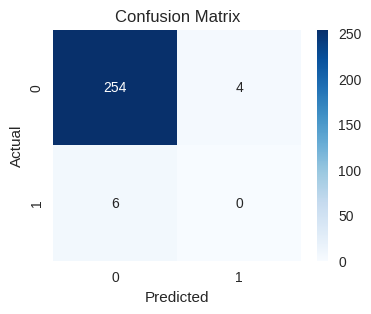

In [16]:
# Execute Step 5
print("\nStep 5: Model Evaluation")
print("-" * 80)
model = evaluate_model(X, y)

In [18]:
# Final Step: Train Final Model and Save
print("\nFinal Step: Training Model on Full Dataset")
print("-" * 80)

# Train final model on all data
final_model = MLPClassifier(
    hidden_layer_sizes=(200,150,50),
    max_iter=300,
    random_state=42
)
final_model.fit(X, y)


Final Step: Training Model on Full Dataset
--------------------------------------------------------------------------------


MLPClassifier(hidden_layer_sizes=(200, 150, 50), max_iter=300, random_state=42)

In [19]:
# Save the model
joblib.dump(final_model, '/content/drive/MyDrive/ML/Music Popularity/spotify_popularity_model.joblib')
print("Final model has been trained on all data and saved")
print("Saved files:")
print("- spotify_popularity_model.joblib (model)")
print("- spotify_scaler.joblib (scaler)")

Final model has been trained on all data and saved
Saved files:
- spotify_popularity_model.joblib (model)
- spotify_scaler.joblib (scaler)
